In [154]:
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [106]:
# Generate measurement data
dt = .001

t_train = np.arange(0, 10, dt)
x0_train = [0, 0.5]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# (1000,2)
x_train = solve_ivp(fun = van_der_pol, 
            t_span = t_train_span, y0 = x0_train, t_eval=t_train,
             **integrator_keywords).y.T

def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return np.array(y).T

In [121]:
# multiple = False
# if multiple:
#     n_trajectories = 20
#     x_train_multi = []
#     x0s = np.random.rand(n_trajectories, dim)
#     for i in range(n_trajectories):
#         x_train_temp = solve_ivp(fun = van_der_pol, t_span=t_train_span, 
#                                     y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
#         x_train_multi.append(x_train_temp)

In [182]:
def create_multiple_timeseries(func, n_trajectories, dim):
    x_train_multi = []
    y_train_multi = []
    x0s = np.random.rand(n_trajectories, dim)
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = func, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        x_train_multi.append(x_train_temp)
    # now get finite difference approximations for each time series
    for x_train in x_train_multi:
        forward_diff = np.expand_dims(np.diff(x_train[:,0]) / dt, axis=1)
        forward_diff2 = np.expand_dims(np.diff(x_train[:,1]) / dt, axis=1)
        y_t = np.concatenate([forward_diff, forward_diff2], axis=1)
        y_train_multi.append(y_t)
    return np.array(x_train_multi)[:,1:,:], np.array(y_train_multi)
    
x_train_multi, y_train_multi = create_multiple_timeseries(van_der_pol, 50, 2)
t_diff = t_train[:-1:]


In [183]:
x_train_multi.shape

(50, 9999, 2)

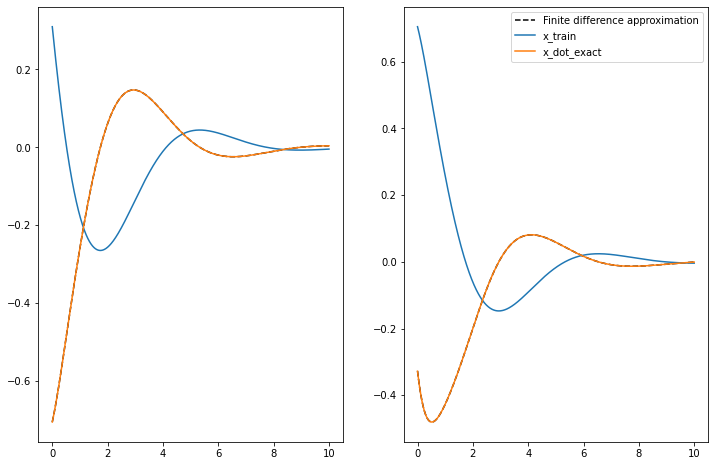

In [184]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.plot(t_diff, y_train_multi[2,:,0], 'k--', \
         label = 'Finite difference approximation')
plt.plot(t_diff, x_train_multi[2,:,0], \
         label = 'x_train')
plt.plot(t_diff, vf(x_train_multi[2,:,:])[:,0], \
         label = 'x_dot_exact')
plt.subplot(122)
plt.plot(t_diff, y_train_multi[2,:,1], 'k--', \
         label = 'Finite difference approximation')
plt.plot(t_diff, x_train_multi[2,:,1], \
         label = 'x_train')
plt.plot(t_diff, vf(x_train_multi[2,:,:])[:,1], \
         label = 'x_dot_exact')
plt.legend()
plt.show()

In [185]:
x_train_multi = np.concatenate(x_train_multi, axis=0)
y_train_multi = np.concatenate(y_train_multi, axis=0)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(x_train_multi, y_train_multi, test_size=0.3, shuffle=True) #, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(349965, 2) (149985, 2) (349965, 2) (149985, 2)


In [201]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))

In [202]:
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# validation_dataset = validation_dataset.shuffle(buffer_size=1024)
batch_size = 64
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))

In [187]:
# x_train_multi = np.array(x_train_multi)
# x_train_multi.shape
# trial = np.concatenate(x_train_multi, axis=0)
# # x_train = trial

In [188]:
# forward_diff = np.expand_dims(np.diff(x_train[:,0]) / dt, axis=1)
# forward_diff2 = np.expand_dims(np.diff(x_train[:,1]) / dt, axis=1)
# y_t = np.concatenate([forward_diff, forward_diff2], axis=1)
# t_diff = t_train[:-1:]
# exact = vf(x_train)[:-1:]

In [189]:
# plt.figure(figsize = (12, 8))
# plt.subplot(121)
# plt.plot(t_diff, y_t[:,0], 'k--', \
#          label = 'Finite difference approximation')
# plt.plot(t_diff, x_train[1:][:,0], \
#          label = 'x_train')
# plt.plot(t_diff, exact[:,0], \
#          label = 'x_dot_exact')
# plt.subplot(122)
# plt.plot(t_diff, y_t[:,1], 'k--', \
#          label = 'Finite difference approximation')
# plt.plot(t_diff, x_train[1:][:,1], \
#          label = 'x_train')
# plt.plot(t_diff, exact[:,1], \
#          label = 'x_dot_exact')
# plt.legend()
# plt.show()

In [190]:
# X_train, X_test, y_train, y_test = train_test_split(x_train[1:], y_t, test_size=0.3, shuffle=True) #, random_state=100)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [191]:
def get_regularised_bn_mlp(input_shape, hidden_units, l2_reg_coeff, dropout_rate):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    
    inputs = Input(shape=input_shape)
    if len(hidden_units) == 0:
        outputs = Dense(1)(inputs)
        return(Model(inputs=inputs, outputs=outputs))
        
    h = Dense(hidden_units[0], activation='relu', kernel_regularizer=regularizers.l2(l2_reg_coeff))(inputs)
    h = BatchNormalization()(h)
    h = Dropout(dropout_rate)(h)
    if len(hidden_units) > 1:
        for i in hidden_units[1:]:
            h = Dense(i, activation='relu', kernel_regularizer=regularizers.l2(l2_reg_coeff))(h)
            h = BatchNormalization()(h)
            h = Dropout(dropout_rate)(h)
    outputs = Dense(2)(h)

    final_model = Model(inputs=inputs, outputs=outputs)
    return(final_model)
# model = get_regularised_bn_mlp((9999,2), [20,128,256,256,512,256], 1e-5, 0)

In [195]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
l2_coeff = 1e-5
rate = 0.5
reg = regularizers.l2(l2_coeff)
act = 'relu'

model = Sequential([
    Dense(20, activation=act, input_dim=2, kernel_regularizer = reg),
    Dense(128, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(512, activation=act, kernel_regularizer = reg),
    Dense(256, activation=act, kernel_regularizer = reg),
    Dense(2)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

In [196]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 20)                60        
                                                                 
 dense_120 (Dense)           (None, 128)               2688      
                                                                 
 dense_121 (Dense)           (None, 256)               33024     
                                                                 
 dense_122 (Dense)           (None, 256)               65792     
                                                                 
 dense_123 (Dense)           (None, 512)               131584    
                                                                 
 dense_124 (Dense)           (None, 256)               131328    
                                                                 
 dense_125 (Dense)           (None, 2)               

In [197]:
history = model.fit(train_dataset, epochs=5, verbose=1, callbacks=[earlystopping])

Epoch 1/5
7812/7812 [==============================] - 31s 4ms/step - loss: 0.0015 - mae: 0.0056
Epoch 2/5
7812/7812 [==============================] - 37s 5ms/step - loss: 2.3006e-04 - mae: 0.0031
Epoch 3/5
7812/7812 [==============================] - 39s 5ms/step - loss: 2.0269e-04 - mae: 0.0027
Epoch 4/5
7812/7812 [==============================] - 38s 5ms/step - loss: 1.6471e-04 - mae: 0.0023
Epoch 5/5
7812/7812 [==============================] - 39s 5ms/step - loss: 1.6063e-04 - mae: 0.0022


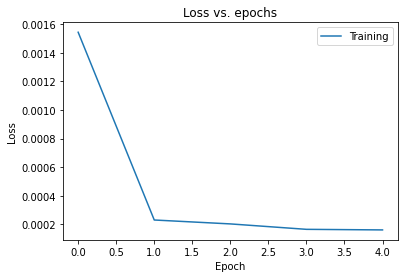

In [198]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation', 'Validation mae'])
plt.show()

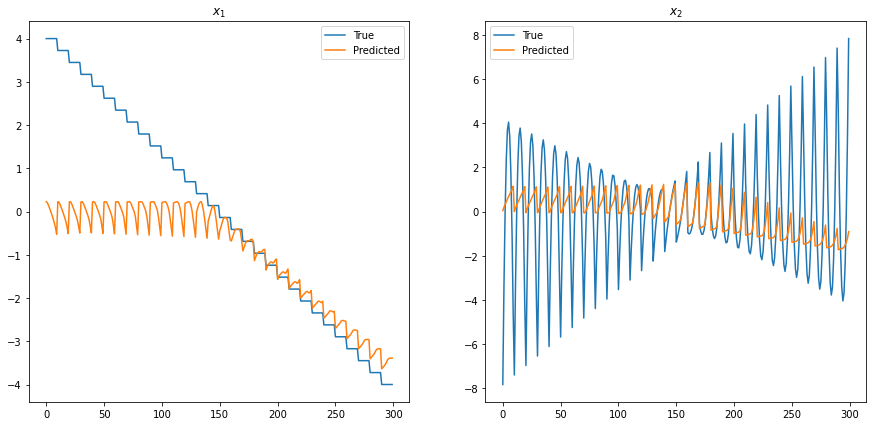

In [199]:
n = [10,30]
bounds = [1.6, 4]
ls = np.stack([n, bounds],axis=1)

def get_grid_of_points(lms):
    ls = [np.linspace(-i,i,int(n)) for n, i in lms]
    mesh_ls = np.meshgrid(*ls)
    all_mesh = [np.reshape(x, [-1]) for x in mesh_ls]
    grid_points = np.stack(all_mesh, axis=1)
    return grid_points
data = get_grid_of_points(ls)

plt.figure(figsize=(15,7))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.plot(vf(data)[:,0], label = 'True')
plt.plot(model.predict(data)[:,0], label = 'Predicted')
plt.title('$x_1$')
plt.legend()
plt.subplot(122)
plt.plot(vf(data)[:,1], label = 'True')
plt.plot(model.predict(data)[:,1], label = 'Predicted')
plt.title('$x_2$')
plt.legend()
plt.show()

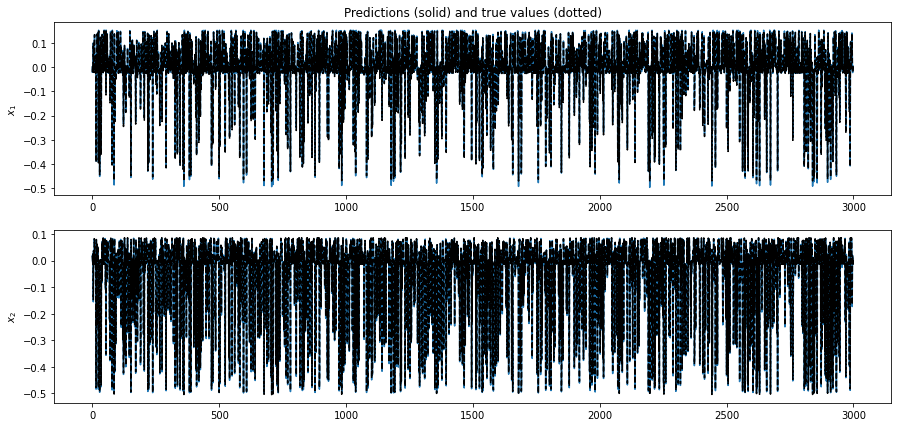

In [104]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(y_test[:,0])
plt.plot(model.predict(X_test)[:,0], 'k--')
plt.title('Predictions (solid) and true values (dotted)')
plt.ylabel('$x_1$')
plt.subplot(212)
plt.plot(y_test[:,1])
plt.plot(model.predict(X_test)[:,1], 'k--')
plt.ylabel('$x_2$')
plt.show()

In [81]:
# # define plotting range and mesh
# bounds = [1.6, 2]
# numpoints = 20
# x = np.linspace(bounds[0], bounds[0], numpoints)
# y = np.linspace(bounds[1], bounds[1], numpoints)

# X, Y = np.meshgrid(x, y)

# s = X.shape

# Ze = np.zeros(s)
# Zp = np.zeros(s)
# DT = np.zeros((numpoints**2,2))

# # convert mesh into point vector for which the model can be evaluated
# c = 0
# for i in range(s[0]):
#     for j in range(s[1]):
#         DT[c,0] = X[i,j]
#         DT[c,1] = Y[i,j]
#         c = c+1;

In [88]:
n = [10,30]
bounds = [1.6, 4]
ls = np.stack([n, bounds],axis=1)

def get_grid_of_points(lms):
    ls = [np.linspace(-i,i,int(n)) for n, i in lms]
    mesh_ls = np.meshgrid(*ls)
    all_mesh = [np.reshape(x, [-1]) for x in mesh_ls]
    grid_points = np.stack(all_mesh, axis=1)
    return grid_points
data = get_grid_of_points(ls)

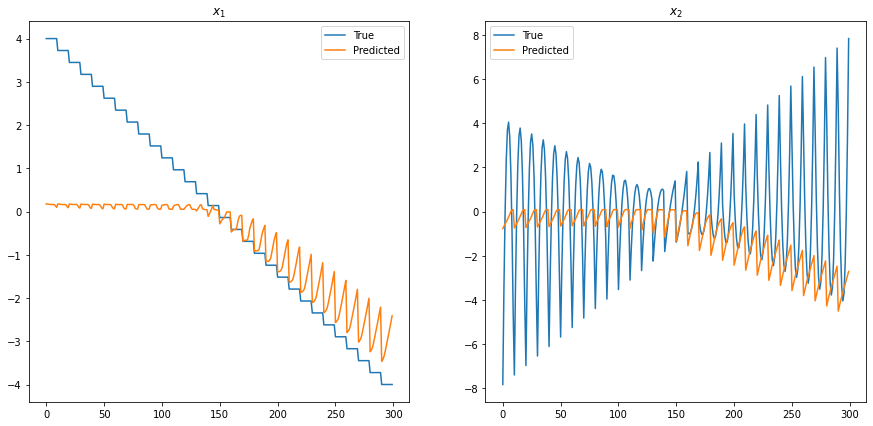

In [87]:
plt.figure(figsize=(15,7))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.plot(vf(data)[:,0], label = 'True')
plt.plot(model.predict(data)[:,0], label = 'Predicted')
plt.title('$x_1$')
plt.legend()
plt.subplot(122)
plt.plot(vf(data)[:,1], label = 'True')
plt.plot(model.predict(data)[:,1], label = 'Predicted')
plt.title('$x_2$')
plt.legend()
plt.show()

In [84]:
mse = ((vf(data) - model.predict(data))**2).mean(axis=0)
mse

array([2.79557011, 7.79626024])

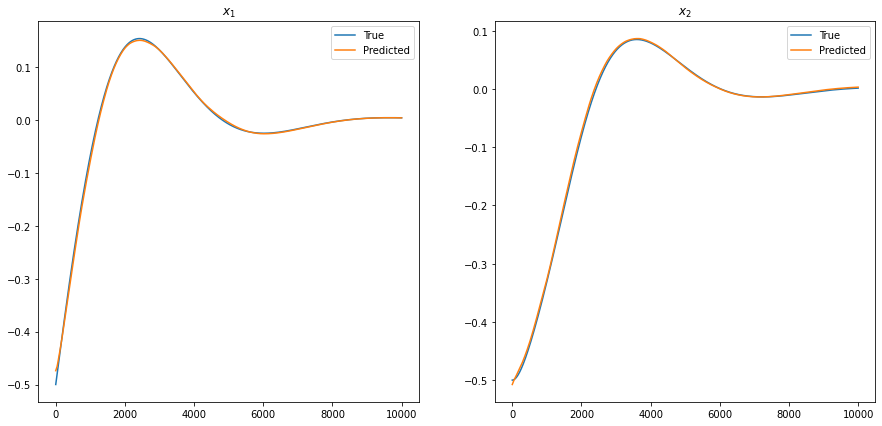

In [101]:
plt.figure(figsize=(15,7))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.plot(vf(x_train)[:,0], label = 'True')
plt.plot(model.predict(x_train)[:,0], label = 'Predicted')
plt.title('$x_1$')
plt.legend()
plt.subplot(122)
plt.plot(vf(x_train)[:,1], label = 'True')
plt.plot(model.predict(x_train)[:,1], label = 'Predicted')
plt.title('$x_2$')
plt.legend()
plt.show()

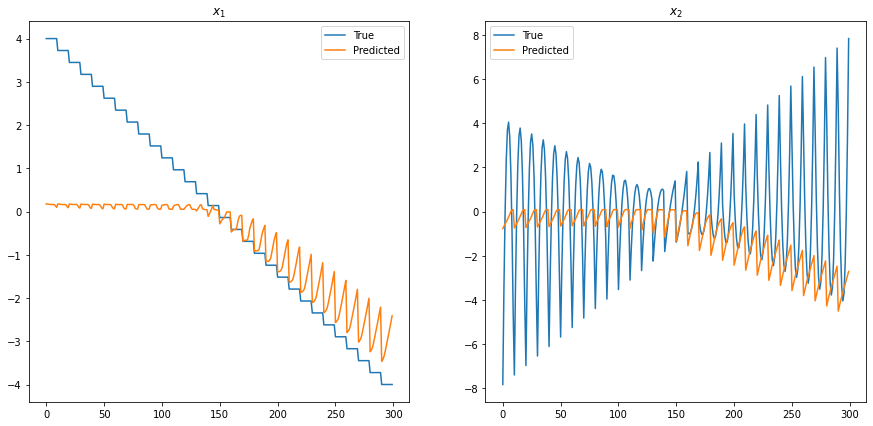

In [102]:
plt.figure(figsize=(15,7))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.plot(vf(data)[:,0], label = 'True')
plt.plot(model.predict(data)[:,0], label = 'Predicted')
plt.title('$x_1$')
plt.legend()
plt.subplot(122)
plt.plot(vf(data)[:,1], label = 'True')
plt.plot(model.predict(data)[:,1], label = 'Predicted')
plt.title('$x_2$')
plt.legend()
plt.show()

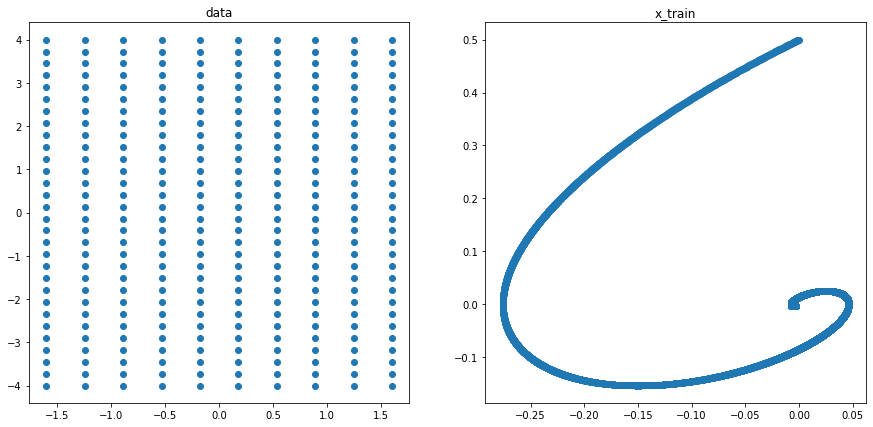

In [100]:
plt.figure(figsize=(15,7))
plt.title('n: {}'.format(n[0]*n[1]))
plt.subplot(121)
plt.scatter(data[:,0], data[:,1])
plt.title('data')
plt.subplot(122)
plt.scatter(x_train[:,0], x_train[:,1])
plt.title('x_train')
plt.show()